In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA

# KOSPI 데이터 가져오기
import yfinance as yf


In [ ]:

# KOSPI 주가지수 데이터 가져오기 (20년치)
data = yf.download('^KS11', start='2004-01-01', end='2024-01-01')

# 주가는 'Adj Close' 컬럼을 사용할 것입니다.
data = data[['Adj Close']]

# prompt: data plot에 보여줘

# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'])
plt.title('KOSPI Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

print(data.shape)

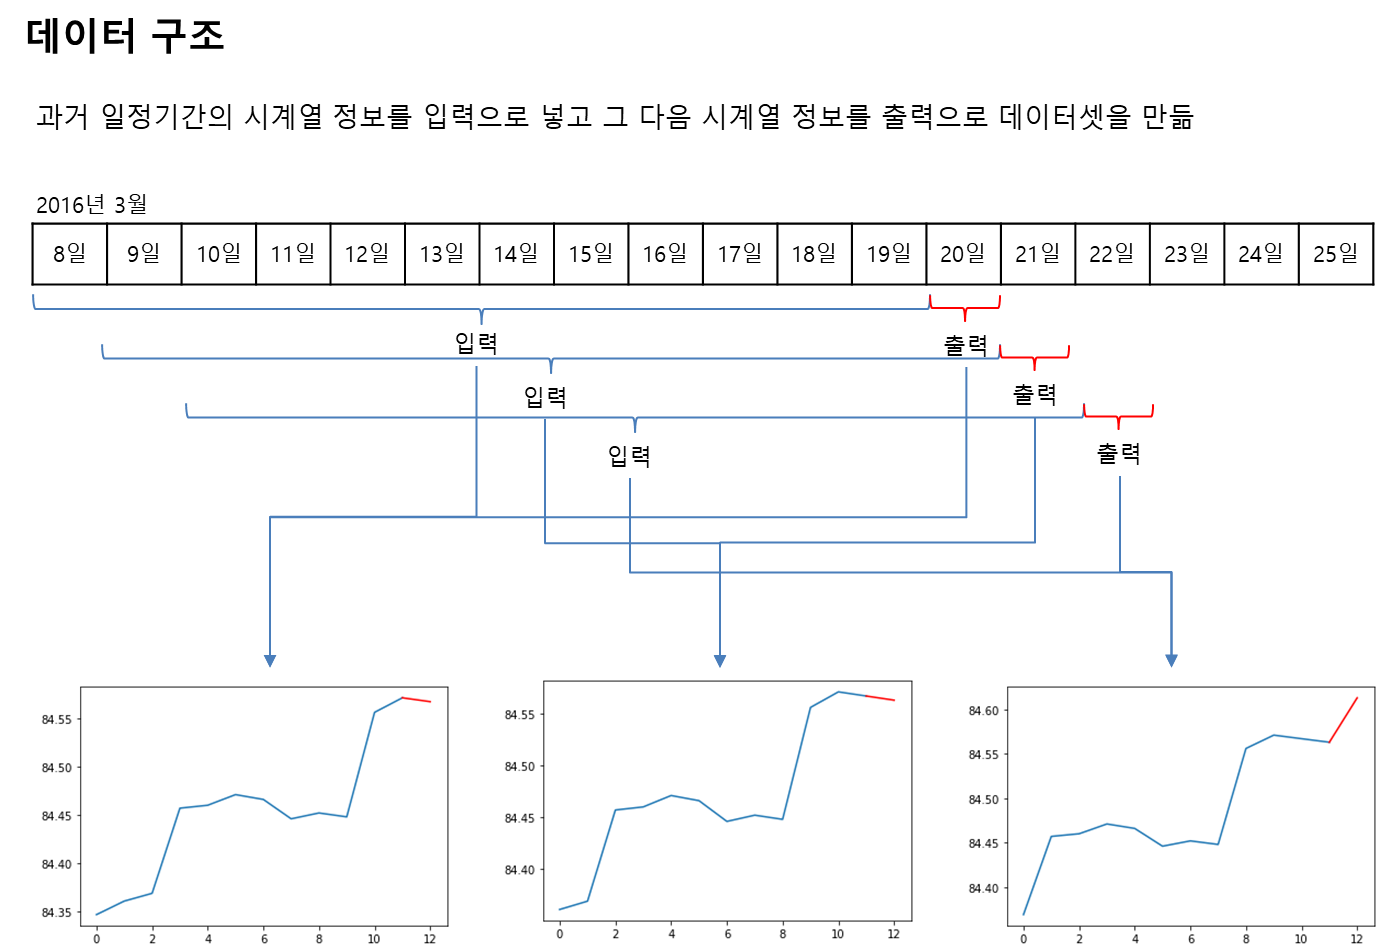

In [ ]:

# 데이터 전처리: MinMax 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 데이터셋을 X, Y로 분리
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)


# X, Y 데이터 생성
time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# X 데이터를 3D 배열로 변환 (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 데이터 분할 (훈련용 / 테스트용)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print(X.shape)
print(Y.shape)

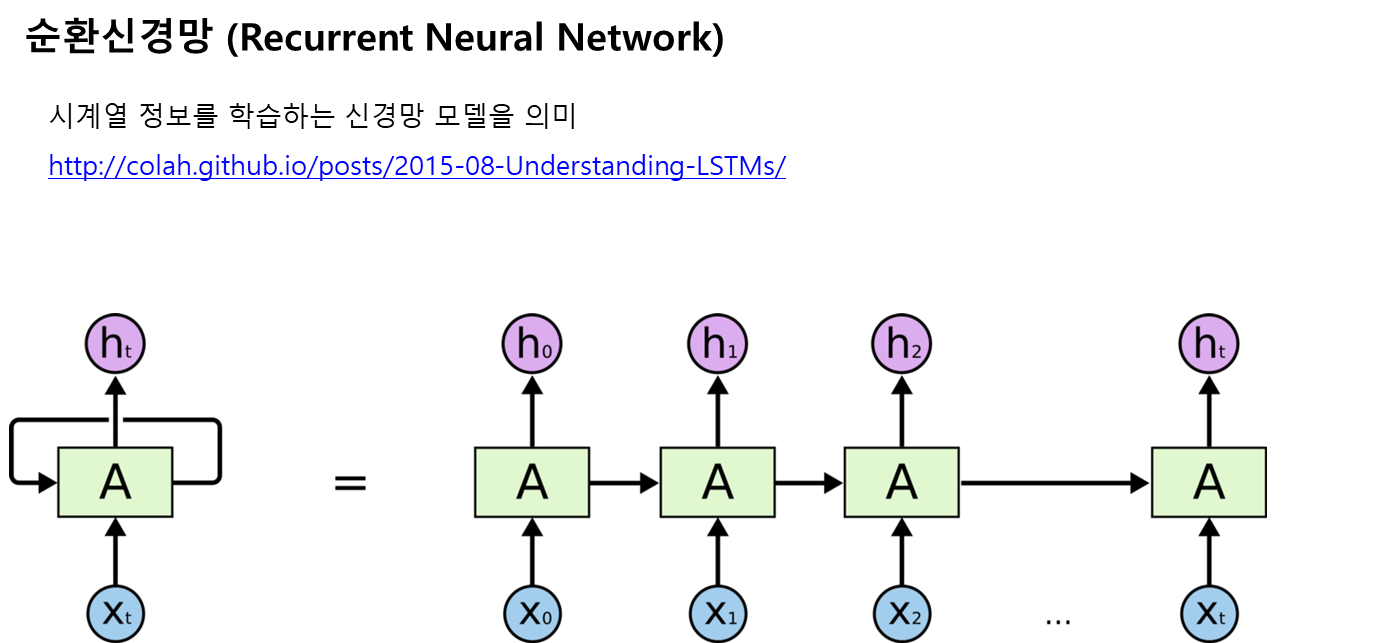

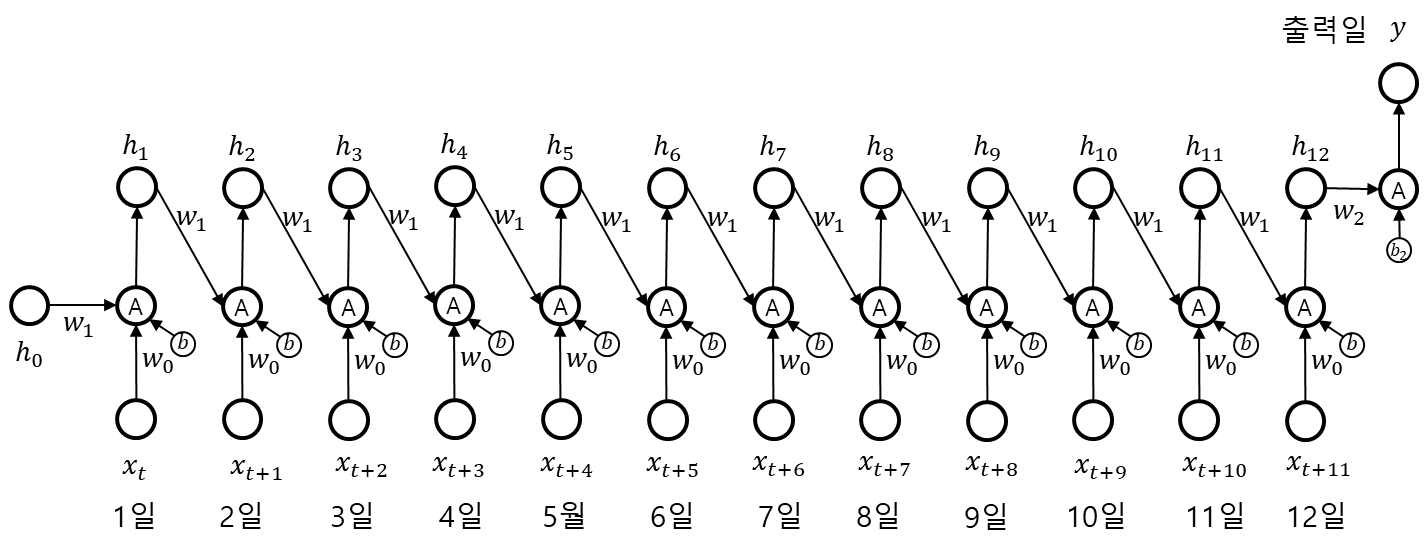

In [ ]:

# 심플 RNN 모델 구축
def build_simple_rnn():
    model = Sequential()
    model.add(SimpleRNN(units=10, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# 모델 학습
rnn_model = build_simple_rnn()
rnn_model.summary()

In [ ]:
rnn_model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

In [ ]:
# 예측 결과
rnn_pred = rnn_model.predict(X_test)

# 예측값 역변환
rnn_pred = scaler.inverse_transform(rnn_pred)

Y_test_inverse = scaler.inverse_transform([Y_test])

# 성능 평가
plt.figure(figsize=(14, 6))
plt.plot(Y_test_inverse[0], label='Actual KOSPI')
plt.plot(rnn_pred, label='RNN Prediction')
plt.title('KOSPI Index Prediction - RNN')
plt.legend()
plt.show()

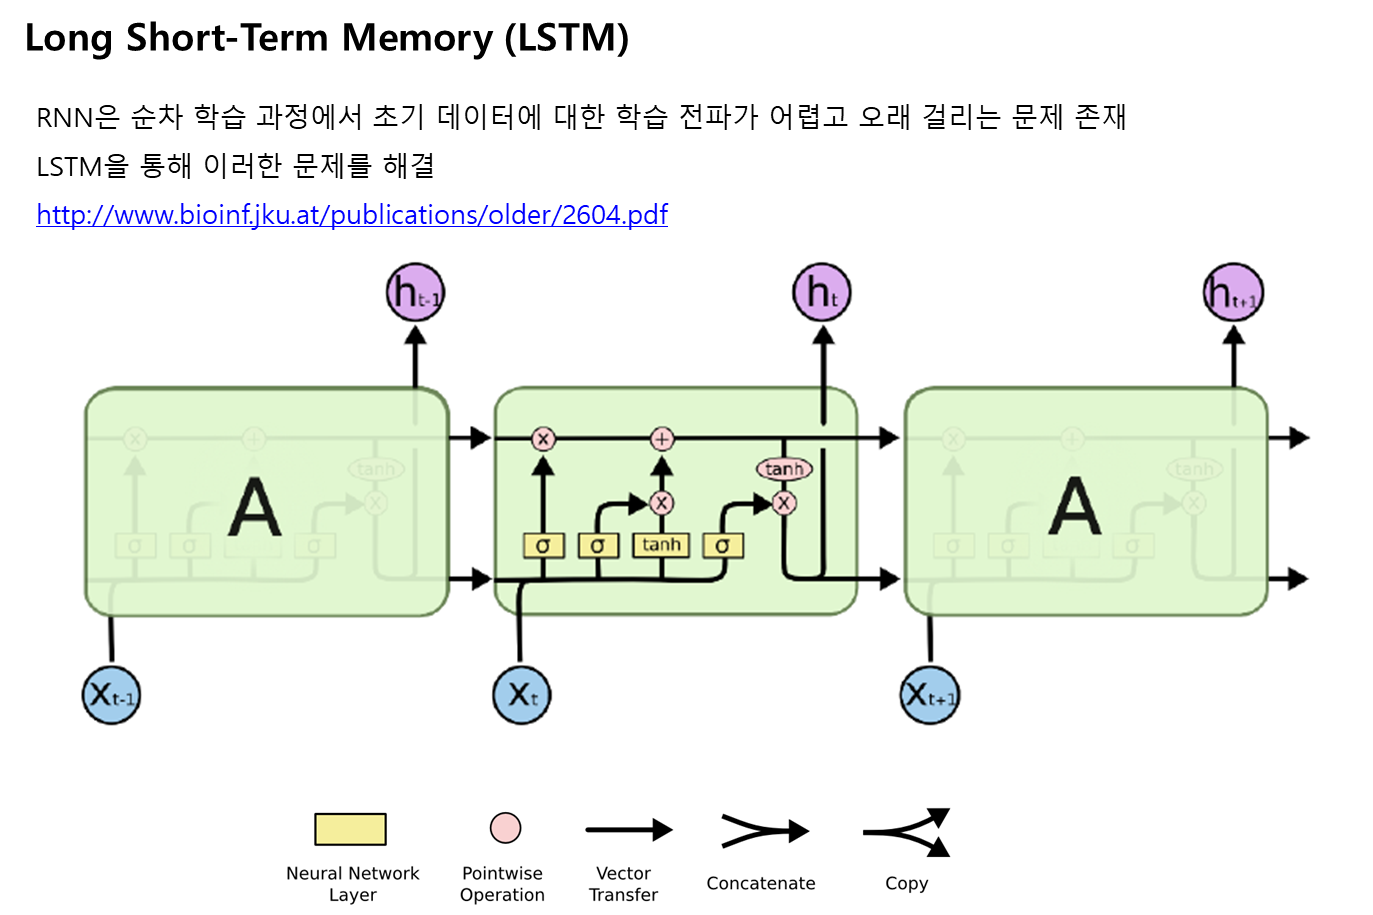

http://www.bioinf.jku.at/publications/older/2604.pdf

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

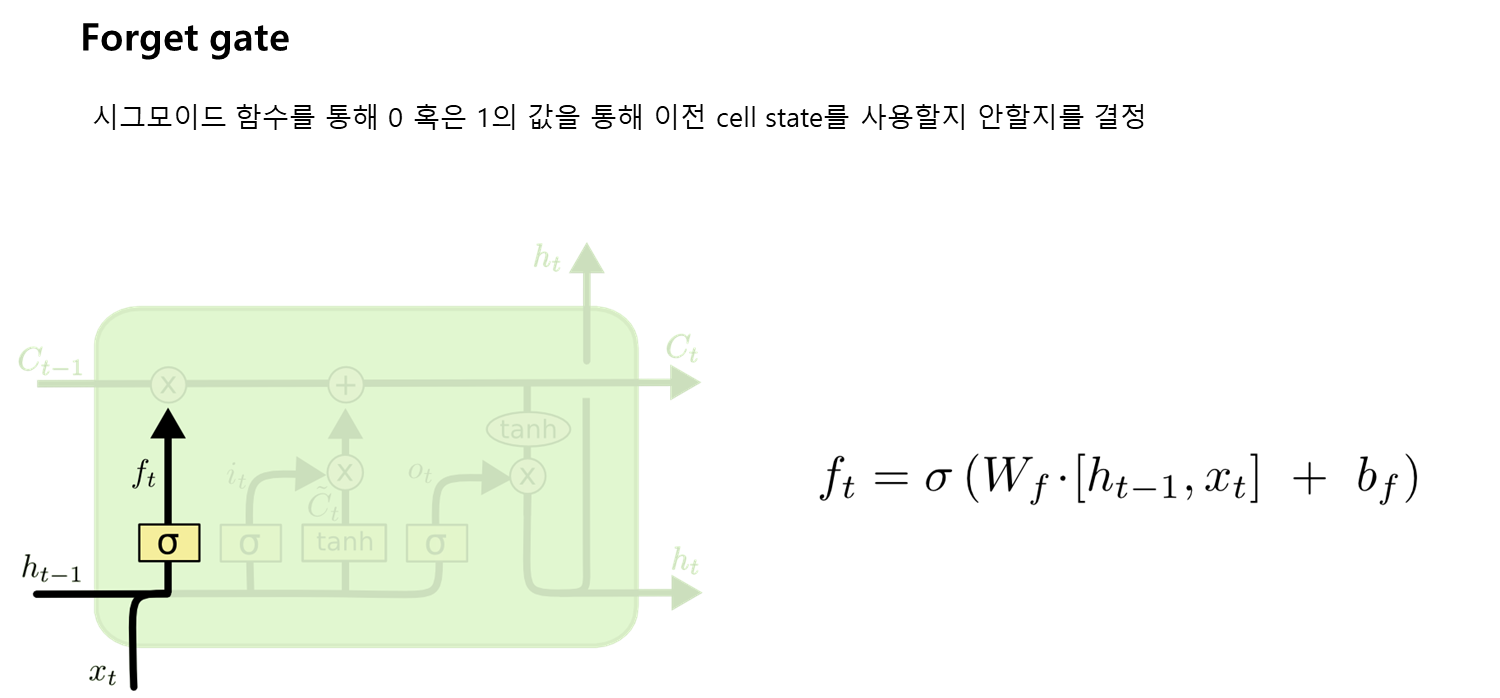

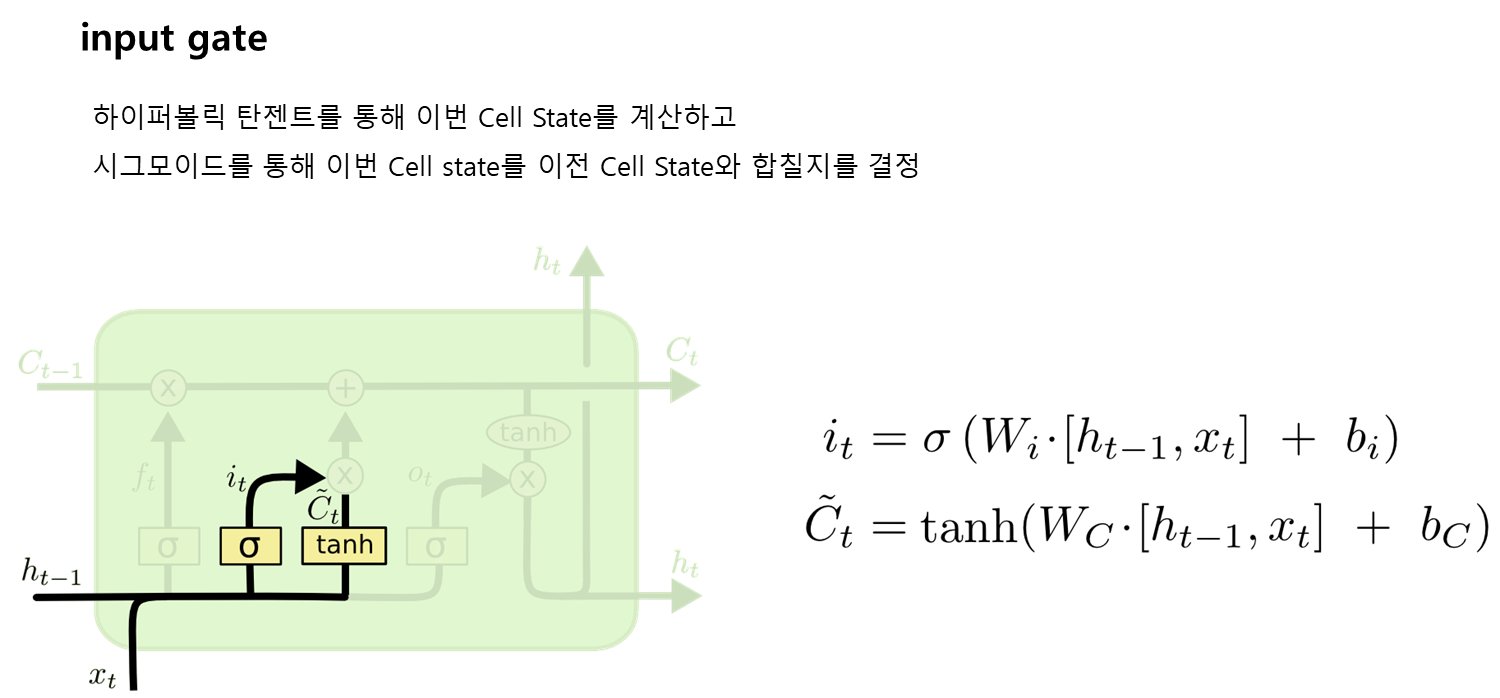

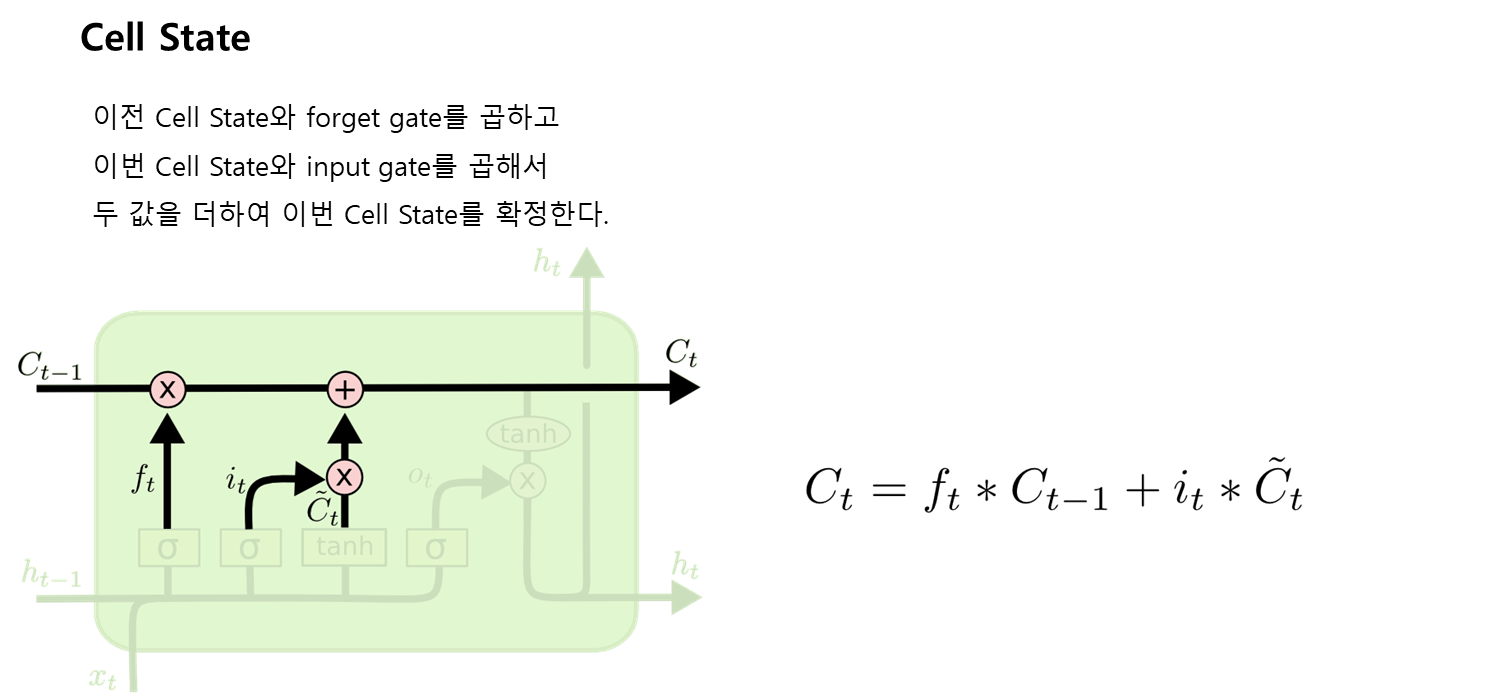

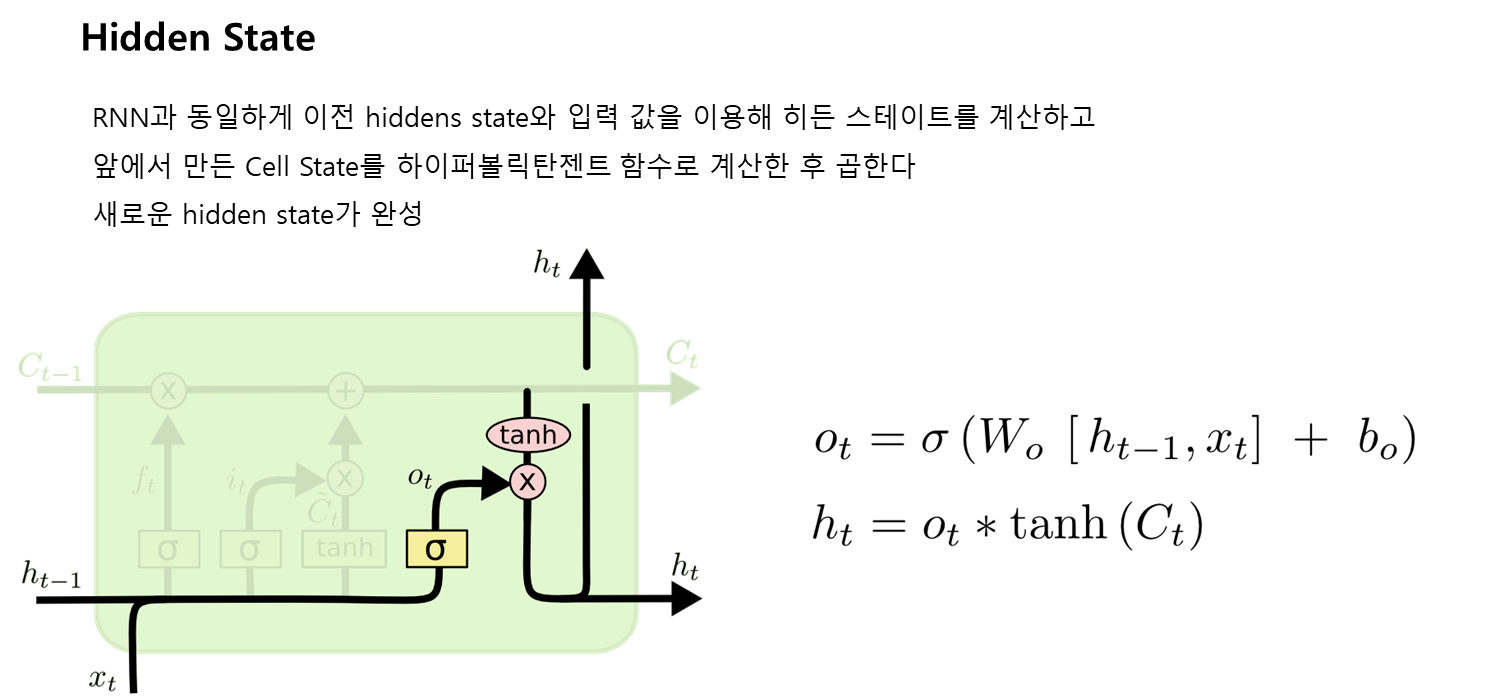

In [ ]:

# LSTM 모델 구축
def build_lstm():
    model = Sequential()
    model.add(LSTM(units=10, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

lstm_model = build_lstm()
lstm_model.summary()

In [ ]:

lstm_model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)


In [ ]:
# 예측 결과
lstm_pred = lstm_model.predict(X_test)

# 예측값 역변환
lstm_pred = scaler.inverse_transform(lstm_pred)

Y_test_inverse = scaler.inverse_transform([Y_test])

# 성능 평가
plt.figure(figsize=(14, 6))
plt.plot(Y_test_inverse[0], label='Actual KOSPI')
plt.plot(lstm_pred, label='LSTM Prediction')
plt.title('KOSPI Index Prediction - LSTM ')
plt.legend()
plt.show()

In [ ]:
# 성능 평가
plt.figure(figsize=(14, 6))
plt.plot(Y_test_inverse[0], label='Actual KOSPI')
plt.plot(rnn_pred, label='RNN Prediction')
plt.plot(lstm_pred, label='LSTM Prediction')
plt.title('KOSPI Index Prediction - RNN vs LSTM')
plt.legend()
plt.show()

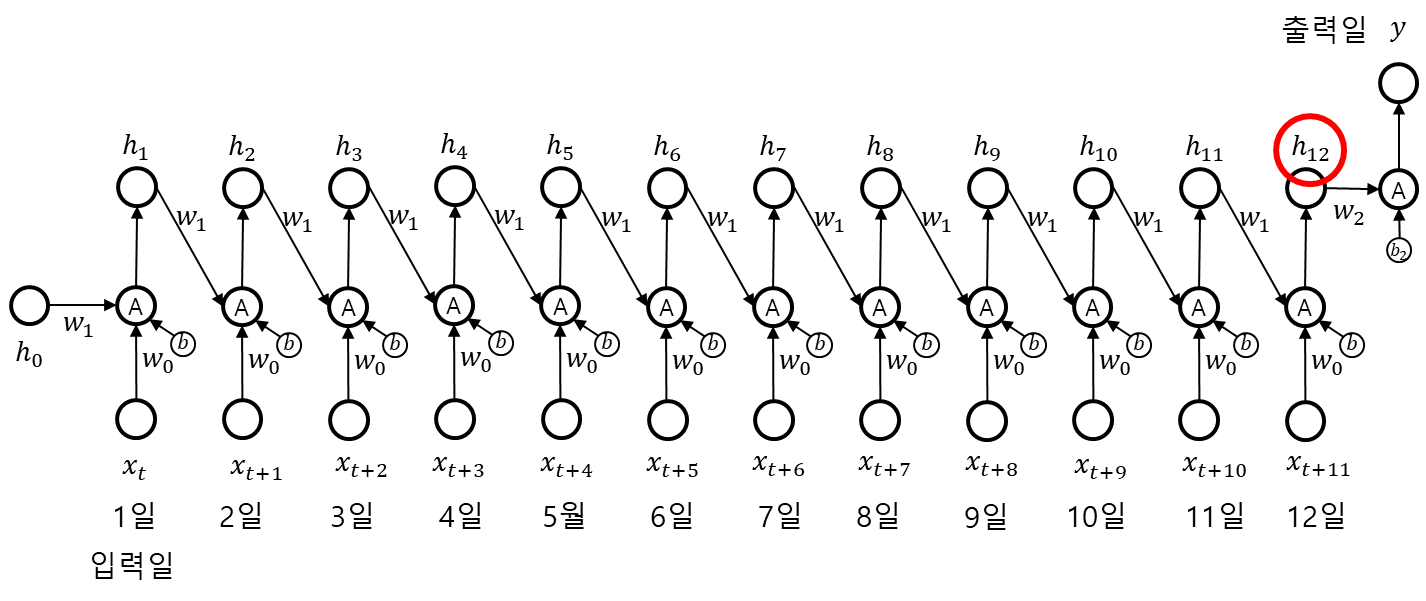

In [ ]:

# RN에서 피처 벡터 추출 (훈련 중간에 피처를 추출하기 위해 모델 수정)
from tensorflow.keras.models import Model

# LSTM 모델에서 마지막 은닉층 출력값을 피처로 사용
feature_extractor = Model(inputs=rnn_model.layers[0].input, outputs=rnn_model.layers[0].output)
rnn_features_train = feature_extractor.predict(X_train)
rnn_features_test = feature_extractor.predict(X_test)

In [ ]:
# prompt: lstm_features_train을 kmeans 클러스터링을 통해 5개로 나누고 centroid에 가장 가까운 데이터 5개의 인덱스를 찾아내어 X_train에서 같은 인덱스의 데이터를 plot으로 클러스터 별로 출력 하는 코드
from sklearn.cluster import KMeans

n_clusters = 10

# KMeans 클러스터링
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(rnn_features_train)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 각 클러스터의 centroid와 가장 가까운 데이터 5개의 인덱스 찾기
closest_indices = []
for i in range(n_clusters):
    cluster_points = rnn_features_train[labels == i]
    distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
    closest_indices.append(np.argsort(distances)[:3] + np.sum(labels < i)) # 클러스터별 인덱스 보정

# 클러스터별로 데이터 출력
plt.figure(figsize=(15, (int(n_clusters/3)+1)*3))

for i in range(n_clusters):
    plt.subplot(int(n_clusters/3)+1, 3, i+1)
    for index in closest_indices[i]:
      plt.plot(X_train[index])
    plt.title(f'Cluster {i}')

plt.tight_layout()
plt.show()

In [ ]:

# 성능 평가 (보조축 추가)
fig, ax1 = plt.subplots(figsize=(14, 6))

# 주축: 실제 KOSPI 및 예측값
ax1.plot(Y_test_inverse[0], label='Actual KOSPI', color='blue')
ax1.plot(rnn_pred, label='RNN Prediction', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('KOSPI Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title('KOSPI Index Prediction - RNN with Cluster Labels')

# 보조축: 클러스터 레이블
ax2 = ax1.twinx()
ax2.set_ylabel('Cluster Label', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# rnn_features_test를 이용하여 클러스터 예측 (테스트 데이터셋 기반)
test_labels = kmeans.predict(rnn_features_test)

# 클러스터 레이블을 플롯에 표시
ax2.plot(test_labels, color='green', alpha=0.5)  # 투명도 조절

plt.show()

In [ ]:

# LSTM에서 피처 벡터 추출 (훈련 중간에 피처를 추출하기 위해 모델 수정)

# LSTM 모델에서 마지막 은닉층 출력값을 피처로 사용
feature_extractor = Model(inputs=lstm_model.layers[0].input, outputs=lstm_model.layers[0].output)
lstm_features_train = feature_extractor.predict(X_train)
lstm_features_test = feature_extractor.predict(X_test)

In [ ]:
# prompt: lstm_features_train을 kmeans 클러스터링을 통해 5개로 나누고 centroid에 가장 가까운 데이터 5개의 인덱스를 찾아내어 X_train에서 같은 인덱스의 데이터를 plot으로 클러스터 별로 출력 하는 코드
from sklearn.cluster import KMeans

n_clusters = 10

# KMeans 클러스터링
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lstm_features_train)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 각 클러스터의 centroid와 가장 가까운 데이터 5개의 인덱스 찾기
closest_indices = []
for i in range(n_clusters):
    cluster_points = lstm_features_train[labels == i]
    distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
    closest_indices.append(np.argsort(distances)[:3] + np.sum(labels < i)) # 클러스터별 인덱스 보정

# 클러스터별로 데이터 출력
plt.figure(figsize=(15, (int(n_clusters/3)+1)*3))

for i in range(n_clusters):
    plt.subplot(int(n_clusters/3)+1, 3, i+1)
    for index in closest_indices[i]:
      plt.plot(X_train[index])
    plt.title(f'Cluster {i}')

plt.tight_layout()
plt.show()

In [ ]:

# 성능 평가 (보조축 추가)
fig, ax1 = plt.subplots(figsize=(14, 6))

# 주축: 실제 KOSPI 및 예측값
ax1.plot(Y_test_inverse[0], label='Actual KOSPI', color='blue')
ax1.plot(lstm_pred, label='LSTM Prediction', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('KOSPI Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title('KOSPI Index Prediction - RNN with Cluster Labels')

# 보조축: 클러스터 레이블
ax2 = ax1.twinx()
ax2.set_ylabel('Cluster Label', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# rnn_features_test를 이용하여 클러스터 예측 (테스트 데이터셋 기반)
test_labels = kmeans.predict(lstm_features_test)

# 클러스터 레이블을 플롯에 표시
ax2.plot(test_labels, color='green', alpha=0.5)  # 투명도 조절

plt.show()